In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import datetime as dt
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from keras.regularizers import l2
from keras.optimizers import Adadelta
from keras.layers import GRU, Dense, LSTM
from keras.callbacks import EarlyStopping

In [145]:
df_stoxx = pd.read_csv('EUROSTOXX50.csv',sep=',').replace(',','',regex=True)# Use the `data` function from `pandas_datareader` to fetch the data
df_dax = pd.read_csv('DAX.csv',sep=',').replace(',','',regex=True)
df_bund = pd.read_csv('BUND.csv',sep=',').replace(',','',regex=True)

In [146]:
df_stoxx=df_stoxx.drop('OpenInt',axis=1)
df_dax=df_dax.drop('OpenInt',axis=1)
df_bund=df_bund.drop('OpenInt',axis=1)

print('all good')

all good


In [147]:
df_stoxx['VAV'] = df_stoxx['Volume']*0.7
df_dax['VAV'] = df_dax['Volume']*0.7
df_bund['VAV'] = df_bund['Volume']*0.7

Change column names.

Current: [Open,High,Low,Last,Volume,Point of Control,Value Area High Value, Value Area Low Value, VAV]

Updated: [Last, Point ofControl, Value Area High Value, Value Area Low Value]

Use df=df.rename(columns={columnold1:columnnew1,columnold2:columnnew2})

In [148]:
df_stoxx = df_stoxx.rename(columns={'Last':'Close','Point of Control':'POC','Value Area High Value':'VAH','Value Area Low Value':'VAL'})
df_dax = df_dax.rename(columns={'Last':'Close','Point of Control':'POC','Value Area High Value':'VAH','Value Area Low Value':'VAL'})
df_bund = df_bund.rename(columns={'Last':'Close','Point of Control':'POC','Value Area High Value':'VAH','Value Area Low Value':'VAL'})

In [149]:
# Count missing values in each column
missing_values_count_stoxx = df_stoxx.isna().sum().sum()
print(missing_values_count_stoxx)
missing_values_count_dax = df_dax.isna().sum().sum()
print(missing_values_count_dax)
missing_values_count_bund = df_bund.isna().sum().sum()
print(missing_values_count_bund)

0
0
0


In [150]:
df_stoxx['Date Time'] = pd.to_datetime(df_stoxx['Date Time'],dayfirst=True) #set dayfirst to True to specify that the first number is the date
df_stoxx.set_index('Date Time',inplace=True)

df_dax['Date Time'] = pd.to_datetime(df_dax['Date Time'],dayfirst=True) #set dayfirst to True to specify that the first number is the date
df_dax.set_index('Date Time',inplace=True)

df_bund['Date Time'] = pd.to_datetime(df_bund['Date Time'],dayfirst=True) #set dayfirst to True to specify that the first number is the date
df_bund.set_index('Date Time',inplace=True)

In [151]:
df_stoxx.head()

,Open,High,Low,Close,Volume,POC,VAH,VAL,VAV
Date Time,,,,,,,,,
2023-03-02,4229,4268,4180,4240,1055634,4240,4245,4215,738943.8
2023-03-01,4227,4281,4209,4216,1015304,4218,4253,4209,710712.8
2023-02-28,4258,4274,4225,4247,981147,4246,4254,4238,686802.9
2023-02-27,4201,4272,4198,4255,970238,4252,4261,4251,679166.6
2023-02-24,4281,4290,4175,4201,1258757,4202,4214,4180,881129.9


In [152]:
#REVERSE DATA SEQUENCE
df_stoxx=df_stoxx[::-1]
df_dax=df_dax[::-1]
df_bund=df_bund[::-1]

Text(0.5, 1.0, 'Bund')

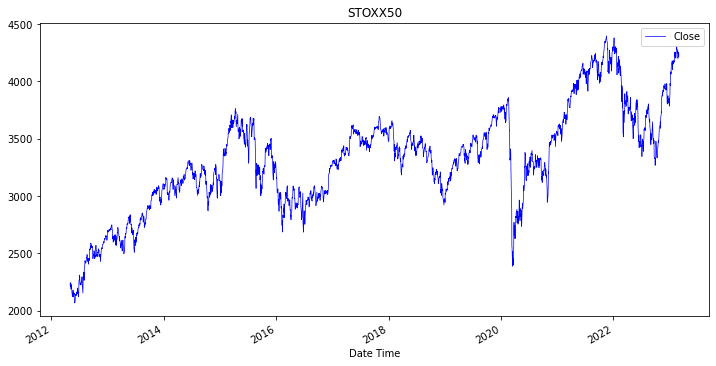

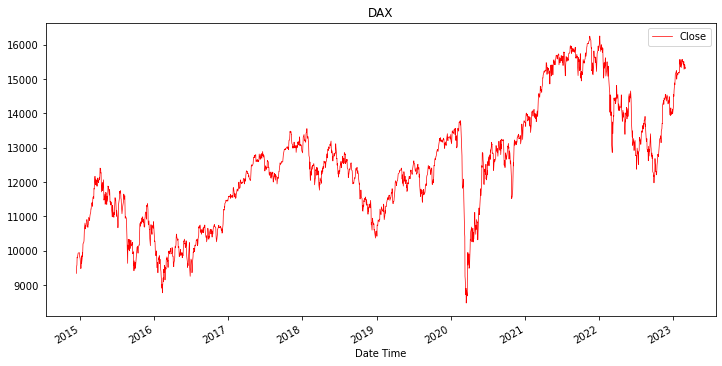

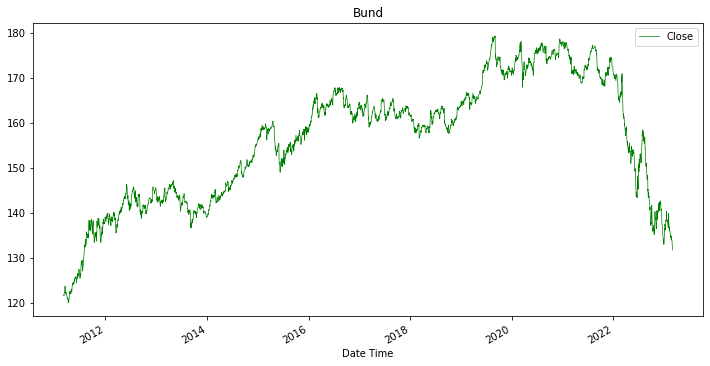

In [153]:
df_stoxx.plot(figsize=(12,6),y='Close',color='blue',linewidth=0.7)
plt.title('STOXX50')

df_dax.plot(figsize=(12,6),y='Close',color='red',linewidth=0.7)
plt.title('DAX')

df_bund.plot(figsize=(12,6),y='Close',color='green',linewidth=0.7)
plt.title('Bund')



Find the volume values that look wrong in DAX's dataset AND Replace

In [154]:
zeros = df_dax[df_dax['Volume'] <= 5]
print(zeros['Volume'])

dax_mean_vol = df_dax['Volume'].mean()

for i in range(len(zeros)):
    outlier_volume = zeros['Volume'][i]
    outlier_VAV = zeros['VAV'][i]
    df_dax['Volume']=df_dax['Volume'].replace(outlier_volume,dax_mean_vol)
    df_dax['VAV']=df_dax['VAV'].replace(outlier_VAV,dax_mean_vol*0.7)

    print('replaced')

Date Time
2021-10-01    1
Name: Volume, dtype: int64
replaced


DATA Details

In [155]:
print('STOXX50:',df_stoxx.shape,' DAX:',df_dax.shape,' BUND:',df_bund.shape)
print('STOXX50: ',df_stoxx.index[0],'-',df_stoxx.index[-1])
print('DAX: ',df_dax.index[0],'-',df_dax.index[-1])
print('BUND: ',df_bund.index[0],'-',df_bund.index[-1])

STOXX50: (2758, 9)  DAX: (2085, 9)  BUND: (3055, 9)
STOXX50:  2012-05-03 00:00:00 - 2023-03-02 00:00:00
DAX:  2014-12-15 00:00:00 - 2023-03-02 00:00:00
BUND:  2011-03-07 00:00:00 - 2023-03-02 00:00:00


NORMALISATION OF THE DATA

In [156]:
#scale the defined columns of the dataframe using the min max out of the selected features
def minmaxcalc(min,max,value):
    minmaxnorm = (value-min)/(max-min)
    return minmaxnorm

def minmaxcustom(dataframe, columns):
    df_new = dataframe.loc[:,columns]
    min_value = df_new.min().min()
    max_value = df_new.max().max()
    df_norm = pd.DataFrame()

    for i in columns:
        df_norm[i]= minmaxcalc(min_value,max_value,df_new[i])

    return df_norm#print(min_value,max_value)


df_stoxx_norm_prices = minmaxcustom(df_stoxx,['Open','High','Low','Close','POC','VAH','VAL'])
df_stoxx_norm_volume = minmaxcustom(df_stoxx,['Volume','VAV'])
df_stoxx_norm = pd.concat([df_stoxx_norm_prices,df_stoxx_norm_volume],axis=1)

df_dax_norm_prices = minmaxcustom(df_dax,['Open','High','Low','Close','POC','VAH','VAL'])
df_dax_norm_volume = minmaxcustom(df_dax,['Volume','VAV'])
df_dax_norm = pd.concat([df_dax_norm_prices,df_dax_norm_volume],axis=1)

df_bund_norm_prices = minmaxcustom(df_bund,['Open','High','Low','Close','POC','VAH','VAL'])
df_bund_norm_volume = minmaxcustom(df_bund,['Volume','VAV'])
df_bund_norm = pd.concat([df_bund_norm_prices,df_bund_norm_volume],axis=1)


In [172]:
features_set1 = df_stoxx_norm[:][['Open','High','Low','Close']]
features_set2 = df_stoxx_norm[:][['Open','High','Low','Close','Volume']]
features_set3 = df_stoxx_norm[:][['Open','High','Low','Close','Volume','POC','VAH','VAL','VAV']]
features_set4 = df_stoxx_norm[:][['POC','VAH','VAL','VAV']]

target_values = df_stoxx_norm[:]['Close']

def input_features(feature_set):
    return feature_set

input = input_features(features_set1)

In [173]:
n_test_stoxx = int(len(input) * 0.2)  # 20% of the data will be used for testing

x_train, y_train = input[:-n_test_stoxx], target_values[:-n_test_stoxx]#, target_values[:-n_test_stoxx], target_values[-n_test_stoxx:]

print(x_train.shape)
print(y_train.shape)



(2207, 4)
(2207,)


SAVE THE TEST SET THAT IS GOING TO EVALUATE THE FINAL MODEL

In [174]:
x_test, y_test = input[-n_test_stoxx:],target_values[-n_test_stoxx:]

print(x_test.shape)
print(y_test.shape)

(551, 4)
(551,)


In [185]:

# Split the first part into 5 overlapping train/validation sets
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

#get length so we don't need to keep writing
length = len(x_train)
print(length)

x_train_flipped = x_train[::-1]
y_train_flipped = y_train[::-1]

# Define window size and batch size
window_size = 5
batch_size = 32

fold_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(x_train)):

    #df.iloc[row_indexer, column_indexer]
    x_train_sequential, y_train_sequential = x_train_flipped.iloc[(length-1)-train_index], y_train_flipped.iloc[(length-1)-train_index]  
    x_validation_sequential, y_validation_sequential = x_train_flipped.iloc[(length-1)-val_index], y_train_flipped.iloc[(length-1)-val_index]

    #print(x_train_sequential.shape)
    #print(x_validation_sequential.shape)
    #print((x_validation_sequential.shape)[0]/((x_validation_sequential.shape)[0]+(x_train_sequential.shape)[0]))  
    #print('FOLD:',fold,'x_train_sequential',x_train_sequential)
    #print('FOLD:',fold,'x_validation_sequential',x_validation_sequential)
    
    #'''

    # RESHAPE TRAIN DATA the input data to create overlapping windows of observations
    x_train_windows = []
    for i in range(window_size, len(x_train_sequential)):
        x_train_windows.append(x_train_sequential[i-window_size:i][:])
    x_train_windows = np.array(x_train_windows)
    # Prepare the output labels
    y_train_windows = y_train_sequential[window_size:]

    # RESHAPE VALIDATION DATA
    x_validation_windows = []
    for i in range(window_size, len(x_validation_sequential)):
        x_validation_windows.append(x_validation_sequential[i-window_size:i][:])
    x_validation_windows = np.array(x_validation_windows)
    # Prepare the output labels
    y_validation_windows = y_validation_sequential[window_size:]
    

    # Define the EarlyStopping callback with a patience of 5 epochs
    early_stop = EarlyStopping(monitor='loss', patience=5)

    # Define and compile the LSTM model
    model = keras.Sequential([
        keras.layers.LSTM(units=64,input_shape=(window_size, x_train_sequential.shape[1]),return_sequences=True),
        #keras.layers.LSTM(units=64,return_sequences=True),
        keras.layers.LSTM(units=256,return_sequences=True),
        keras.layers.LSTM(units=64),#64 256 64
        keras.layers.Dense(units=1)
    ])
    model.compile(loss='mse', optimizer='adam')

    # Train the model in batches
    model.fit(x_train_windows, y_train_windows, batch_size=batch_size, epochs=50, callbacks=[early_stop],verbose=0)#,validation_data=(x_validation_windows, y_validation_windows))

    train_loss = model.evaluate(x_train_windows, y_train_windows, verbose=0)
    print("Train_Loss= ",train_loss)

    fold_score = model.evaluate(x_validation_windows, y_validation_windows, verbose=0)
    print('Validation score',fold_score)
    fold_scores.append(fold_score)

# Print average validation score across all folds
print('Average validation score:', np.mean(fold_scores))

#'''


2207
Train_Loss=  0.0004513672029133886
Validation score 0.000763740565162152
Train_Loss=  0.0005002192920073867
Validation score 0.0014241484459489584
Train_Loss=  0.0014246526407077909
Validation score 0.00197158707305789
Train_Loss=  0.0006806548335589468
Validation score 0.00047192376223392785
Train_Loss=  0.0006766072474420071
Validation score 0.0020609968341886997
Average validation score: 0.0013384793361183255


In [169]:
#===============CHECK SEQUENCE ORDER==========LOOKS OK
'''
x_train_windows = []
for i in range(window_size, len(x_train_sequential)):
    x_train_windows.append(x_train_sequential[i-window_size:i][:])
x_train_windows = np.array(x_train_windows)
# Prepare the output labels
y_train_windows = y_train_sequential[window_size:]

print(x_train_sequential.head())

print(x_train_windows)
print('y_train_sequential')
print(y_train_sequential)

print('y_train_sequential')
print(y_train_windows)
'''

In [181]:
x_train_windows

array([[[0.09407812, 0.10583788, 0.08315834, 0.08819824],
        [0.08273835, 0.09659807, 0.07265855, 0.07601848],
        [0.05291894, 0.09449811, 0.04955901, 0.09113818],
        [0.09071819, 0.09239815, 0.06761865, 0.07097858],
        [0.07601848, 0.07853843, 0.05417892, 0.06719866]],

       [[0.08273835, 0.09659807, 0.07265855, 0.07601848],
        [0.05291894, 0.09449811, 0.04955901, 0.09113818],
        [0.09071819, 0.09239815, 0.06761865, 0.07097858],
        [0.07601848, 0.07853843, 0.05417892, 0.06719866],
        [0.07139857, 0.08567829, 0.06257875, 0.07937841]],

       [[0.05291894, 0.09449811, 0.04955901, 0.09113818],
        [0.09071819, 0.09239815, 0.06761865, 0.07097858],
        [0.07601848, 0.07853843, 0.05417892, 0.06719866],
        [0.07139857, 0.08567829, 0.06257875, 0.07937841],
        [0.07097858, 0.08651827, 0.0650987 , 0.08441831]],

       ...,

       [[0.61108778, 0.62074759, 0.60184796, 0.60562789],
        [0.60352793, 0.61528769, 0.60310794, 0.610247